# **Tomato Leaf Disease Classification**
- **Nama:** Kevin Aditya Ikhsan
- **Email:** kevinadityaikhsan15@gmail.com
- **ID Dicoding:** kevinadityaikhsan

Tomato plants are susceptible to a variety of diseases that can significantly impact crop yield and quality. Early and accurate detection of these diseases is crucial for effective management and control. This project aims to leverage machine learning to develop a lightweight model capable of identifying tomato leaf diseases from images. The dataset used in this project contains over 20,000 images of tomato leaves, categorized into 10 different disease classes and 1 healthy class. These images are collected from both controlled laboratory environments and natural, in-the-wild settings, providing a diverse range of conditions for the model to learn from.

The primary objective is to create a model that not only achieves high accuracy but is also efficient enough to be deployed across various platforms, including servers, web browsers, and edge devices like smartphones and IoT devices. This versatility ensures that the model can be used in different scenarios, from large-scale agricultural monitoring systems to individual farmers using mobile apps in the field.

**Classes:**

1. **Late Blight**: A serious disease caused by the oomycete Phytophthora infestans, leading to significant crop losses.

2. **Healthy**: Leaves that show no signs of disease, representing the baseline for comparison.
3. **Early Blight**: Caused by the fungus Alternaria solani, characterized by concentric rings on the leaves.
4. **Septoria Leaf Spot**: A fungal disease caused by Septoria lycopersici, resulting in small, circular spots on the leaves.
5. **Tomato Yellow Leaf Curl Virus**: A viral disease transmitted by whiteflies, causing yellowing and curling of leaves.
6. **Bacterial Spot**: Caused by Xanthomonas campestris, leading to dark, water-soaked spots on leaves.
7. **Target Spot**: A fungal disease caused by Corynespora cassiicola, characterized by target-like spots on the leaves.
8. **Tomato Mosaic Virus**: A viral disease causing mottling and distortion of leaves.
9. **Leaf Mold**: Caused by the fungus Passalora fulva, leading to yellow spots on the upper leaf surface and mold growth on the underside.
10. **Spider Mites (Two-Spotted Spider Mite)**: Tiny arachnids that cause stippling and discoloration of leaves.
11. **Powdery Mildew**: A fungal disease that produces white, powdery spots on leaves and stems.

**Methodology:**

The project follows a standard machine learning workflow, including data preprocessing, model training, evaluation, and optimization.

1. **Data Preprocessing:** The images are resized and augmented to increase the dataset size and improve model robustness. Data augmentation techniques such as rotation, flipping, and zooming are applied to create variations of the original images.
2. **Model Training:** A convolutional neural network (CNN) is trained using the preprocessed dataset. The model architecture is designed to be lightweight and efficient, while still achieving high accuracy. Transfer learning is used, leveraging a pre-trained model EfficientNetB0 as a base and fine-tuning it on the tomato leaf disease dataset.
3. **Evaluation:** The model's performance is evaluated using accuracy score metric. The metric provide a comprehensive understanding of the model's ability to correctly classify tomato leaf diseases.

**Deployment:**

The trained model can be deployed on various platforms, including servers, web browsers, and edge devices. This allows for real-time disease detection and enables timely intervention to prevent crop losses. The model can be integrated into mobile applications, web services, or embedded systems for easy access and utilization by farmers and agricultural professionals.

By developing a robust and efficient model, this project aims to provide a valuable tool for farmers and agricultural professionals, helping them to quickly and accurately diagnose tomato leaf diseases and take appropriate action to protect their crops.

[Dataset](https://www.kaggle.com/datasets/ashishmotwani/tomato)

[Repository](https://github.com/kevinadityaikhsan/tomato_leaf_disease_classification)


# **1. Data Loading**

## **1.1. Import Libraries**

In [ ]:
!pip install tensorflowjs --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 62.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import os
import shutil
from PIL import Image
import random
import requests

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    BatchNormalization,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')


## **1.2. Create Functions**

In [ ]:
# @title **show_image_samples** {display-mode: "form"}
def show_image_samples(df, title):
    """
    Displays one sample image randomly chosen from each class (label) in the DataFrame.

    Args:
        df: The DataFrame containing image paths and labels.
        title: The title of the plot.
    """

    # Get unique labels and the number of unique labels
    unique_labels = df['label'].unique()
    num_labels = len(unique_labels)

    plt.figure(figsize=(16, 3 * (num_labels // 5 + 1)))
    plt.suptitle(title, fontsize=16)

    for i, label in enumerate(unique_labels):
        # Filter DataFrame for the current label
        label_df = df[df['label'] == label]

        # Randomly select one image from the filtered DataFrame
        random_image_index = random.randint(0, len(label_df) - 1)
        image_path = label_df['image'].iloc[random_image_index]

        img = Image.open(image_path)
        plt.subplot(num_labels // 5 + 1, 4, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# @title **analyze_image_dimensions** {display-mode: "form"}
def analyze_image_dimensions(df, image_column='', dataset_name='', ax=None):
    """
    Analyzes and plots the distribution of image dimensions (width and height) within a specified DataFrame.

    Args:
        df: The DataFrame containing image paths.
        image_column: The name of the column in the DataFrame that holds the image paths.
        dataset_name: A string to identify the dataset in the plot titles (optional).
        ax: The axes object to plot on (optional).

    Returns:
        None
    """

    widths = []
    heights = []

    for image_path in df[image_column]:
        try:
            img = Image.open(image_path)
            width, height = img.size
            widths.append(width)
            heights.append(height)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    dimensions_df = pd.DataFrame({'width': widths, 'height': heights})

    # If ax is not provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 6))

    # Plotting
    ax.hist(dimensions_df['width'], bins=50, alpha=0.7, label='Width')
    ax.hist(dimensions_df['height'], bins=50, alpha=0.7, label='Height')
    ax.set_xlabel('Dimension (pixels)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of Image Dimensions ({dataset_name})')
    ax.legend()

    # If ax was provided, don't show the plot here, it will be shown later
    if ax is None:
        plt.tight_layout()
        plt.show()


In [ ]:
# @title **create_bar_chart** {display-mode: "form"}
def create_bar_chart(series, axis, title, xlabel, ylabel, limit=None, ax=None):
    """
    Visualizes the values in a pandas Series on descending order using a bar chart.

    Args:
        series: The pandas Series to visualize.
        axis: The axis on which to plot the values ('x' or 'y')
        title: The title of the plot.
        xlabel: The label for the x-axis.
        ylabel: The label for the y-axis.
        limit: (Optional) The number of values to display.
        ax: (Optional) The matplotlib axes object to plot on.

    Returns:
        None
    """

    # Sort the series in descending order before applying the limit
    series = series.sort_values(ascending=False)

    # Handle cases where there are fewer unique values than the specified limit
    if limit is None or limit > len(series):
        limit = len(series)

    series = series.head(limit)

    # Convert index to strings for consistent handling
    series.index = series.index.astype(str)

    # Create a figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 6))

    if axis == 'x':
        sns.barplot(x=series.index, y=series.values, palette='viridis', ax=ax)
        ax.set_xticklabels(
            [label[:15] + ('...' if len(label) > 15 else '') for label in series.index],
            rotation=45
        )
        for i, value in enumerate(series.values):
            if value >= 1000:
                simplified_value = f"{value/1000:.1f}k"
            else:
                simplified_value = str(value)
            ax.text(i, value, simplified_value, ha='center', va='bottom')

    elif axis == 'y':
        sns.barplot(x=series.values, y=series.index, palette='viridis', ax=ax)
        ax.set_yticks(range(len(series)),
                        [label[:15] + ('...' if len(label) > 15 else '') for label in series.index])
        for i, value in enumerate(series.values):
            if value >= 1000:
                simplified_value = f"{value/1000:.1f}k"
            else:
                simplified_value = str(value)
            ax.text(value, i, simplified_value, ha='left', va='center')
    else:
        print(f"Error: Invalid axis '{axis}'. Please choose 'x' or 'y'.")
        return

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Adjust layout if plotting on a new figure
    if ax is None:
        plt.tight_layout()
        plt.show()


## **1.3. Load Datasets**

In [ ]:
# Download the tomato dataset from Kaggle.
!kaggle datasets download -d ashishmotwani/tomato
!unzip -qq tomato.zip -d /content/tomato
!rm tomato.zip


Dataset URL: https://www.kaggle.com/datasets/ashishmotwani/tomato
License(s): copyright-authors
100% 1.36G/1.37G [00:22<00:00, 77.7MB/s]
100% 1.37G/1.37G [00:22<00:00, 66.0MB/s]


In [ ]:
# Function to create a DataFrame with 'image' and 'label' columns
# from a directory structure.
def create_image_dataframe(data_dir):
  """Creates a DataFrame with 'image' and 'label' columns from a
  directory structure where subdirectories represent labels."""

  images = []
  labels = []

  for subfolder in os.listdir(data_dir):
    subfolder_path = os.path.join(data_dir, subfolder)
    if os.path.isdir(subfolder_path):
      for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

  return pd.DataFrame({'image': images, 'label': labels})

# Create a DataFrame from the training dataset directory.
train_dir = 'tomato/train'
df = create_image_dataframe(train_dir)


# **2. Exploratory Data Analysis**

*   **Display sample images from each class in the DataFrame**: Analyze visual diversity of the dataset and understand the distinctive characteristics of each disease class, aiding in identifying potential challenges for the model.

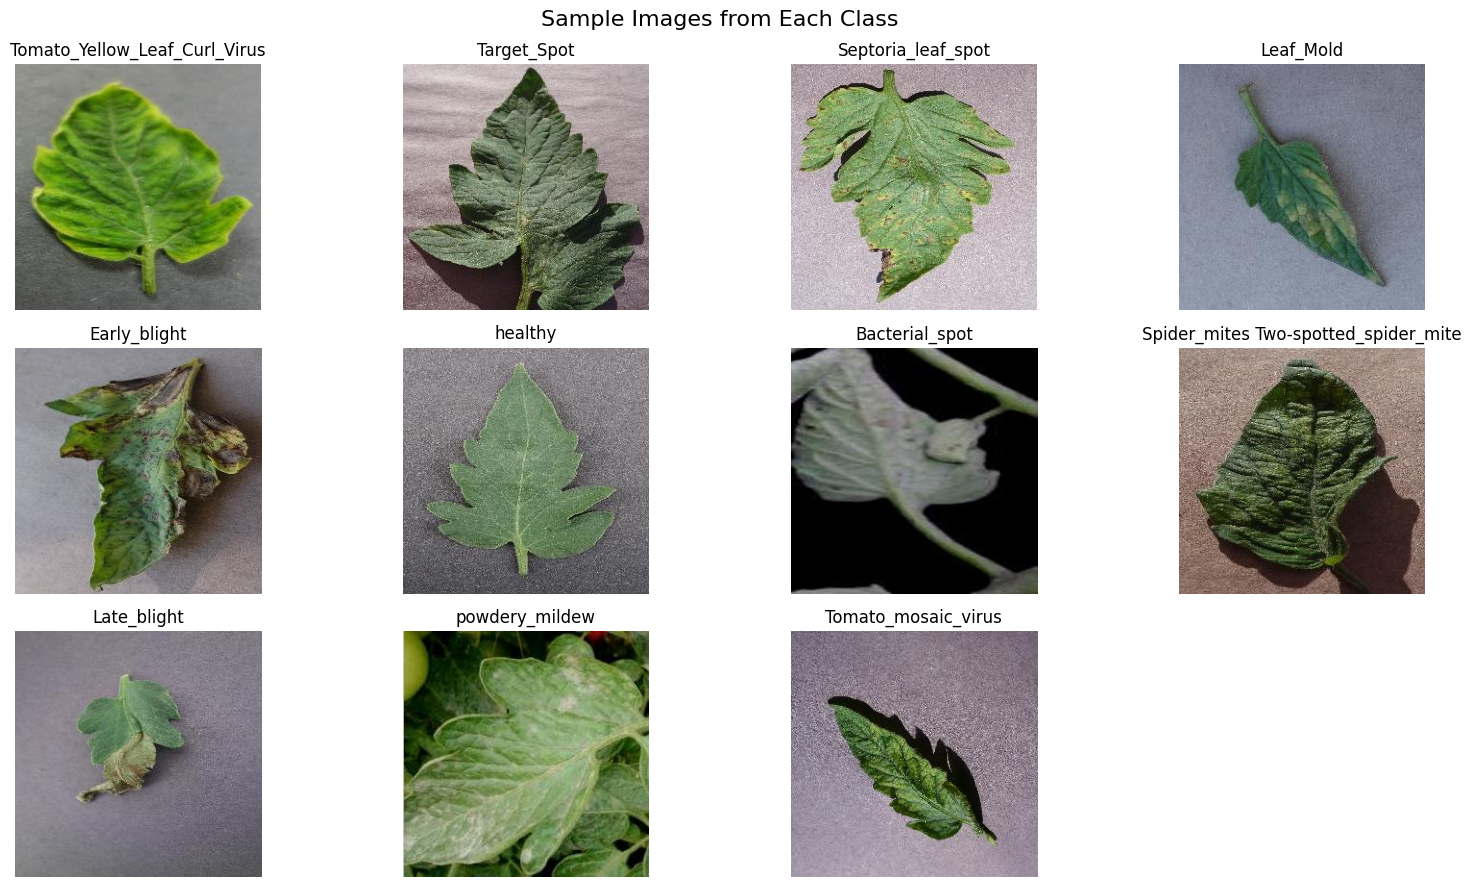

In [ ]:
# Display sample images from each class in the DataFrame.
show_image_samples(df, 'Sample Images from Each Class')


*   **Analyze the dimensions of images in the DataFrame**: By examining the image sizes, it can determine if resizing or standardization is necessary to ensure consistency in the input data, which is crucial for optimal model performance.


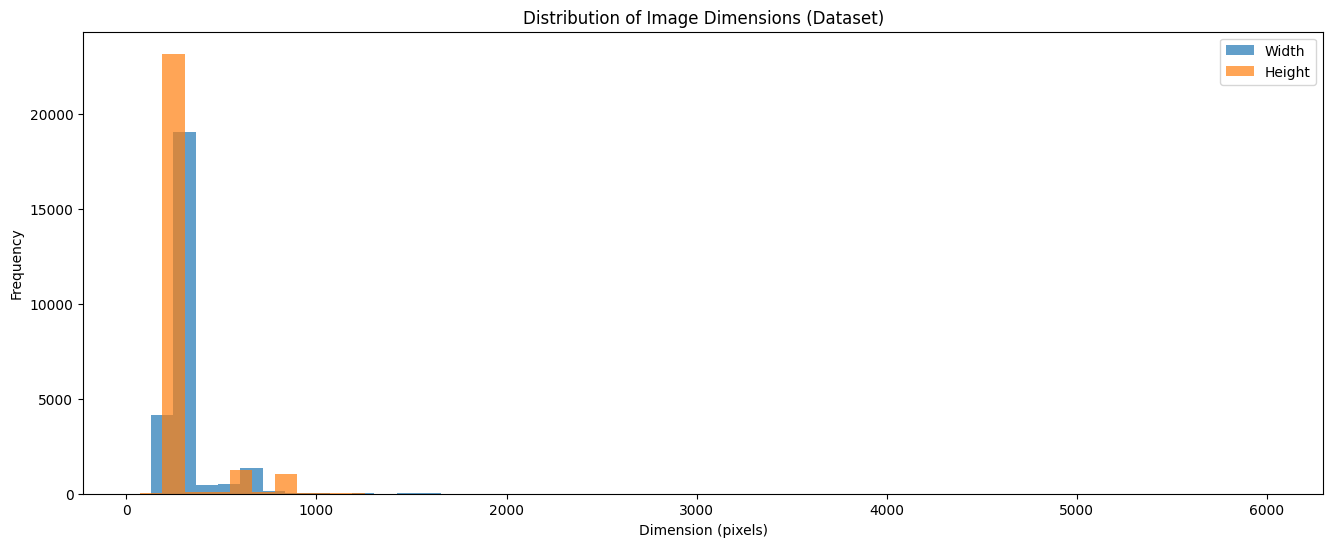

In [ ]:
# Analyze the dimensions of images in the DataFrame.
analyze_image_dimensions(df, 'image', 'Dataset')


*   **Show the number of images per class**: Class distribution highlighting any potential imbalances that may need to be addressed during training, such as through class weights or data augmentation techniques to prevent the model from being biased towards the majority classes.


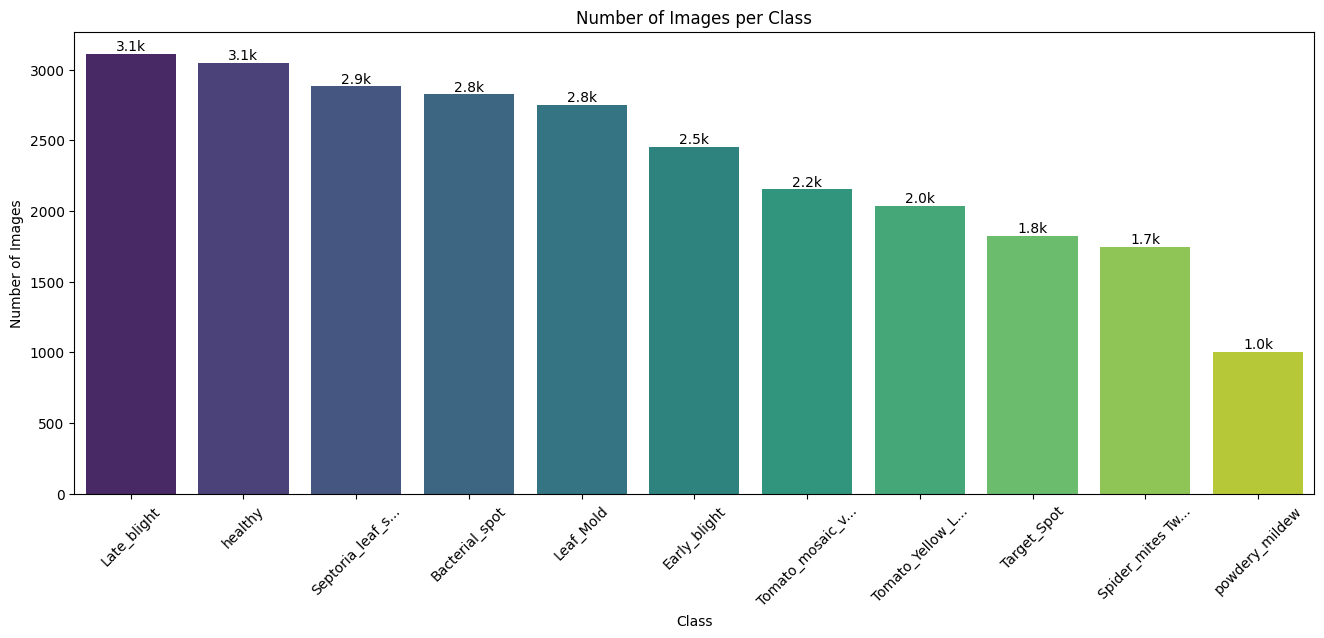

In [ ]:
# Create a bar chart showing the number of images per class.
create_bar_chart(
    df['label'].value_counts(),
    'x',
    'Number of Images per Class',
    'Class', 'Number of Images'
)



- **Sampling images per class:** Ensure a balanced representation of each disease class during model training.
This helps prevent the model from being biased towards classes with a larger number of images and ensures that it learns to accurately identify all disease types, even those with fewer examples in the dataset.
By maintaining a consistent sample size across classes, the model's ability to generalize to unseen data is improved, leading to better overall performance and robustness.


In [ ]:
# Create a dictionary to store the sampled images for each class
sampled_images = {}

# Iterate through the unique labels in the DataFrame
for label in df['label'].unique():
  label_df = df[df['label'] == label]

  if len(label_df) >= 1000:
    sampled_label_df = label_df.sample(n=1000, random_state=42)
  else:
    sampled_label_df = label_df

  sampled_images[label] = sampled_label_df

# Concatenate the sampled images for each label into a new DataFrame
sampled_df = pd.concat(sampled_images.values(), ignore_index=True)
print(f"Number of images in the sampled DataFrame: {len(sampled_df)}")


Number of images in the sampled DataFrame: 11000


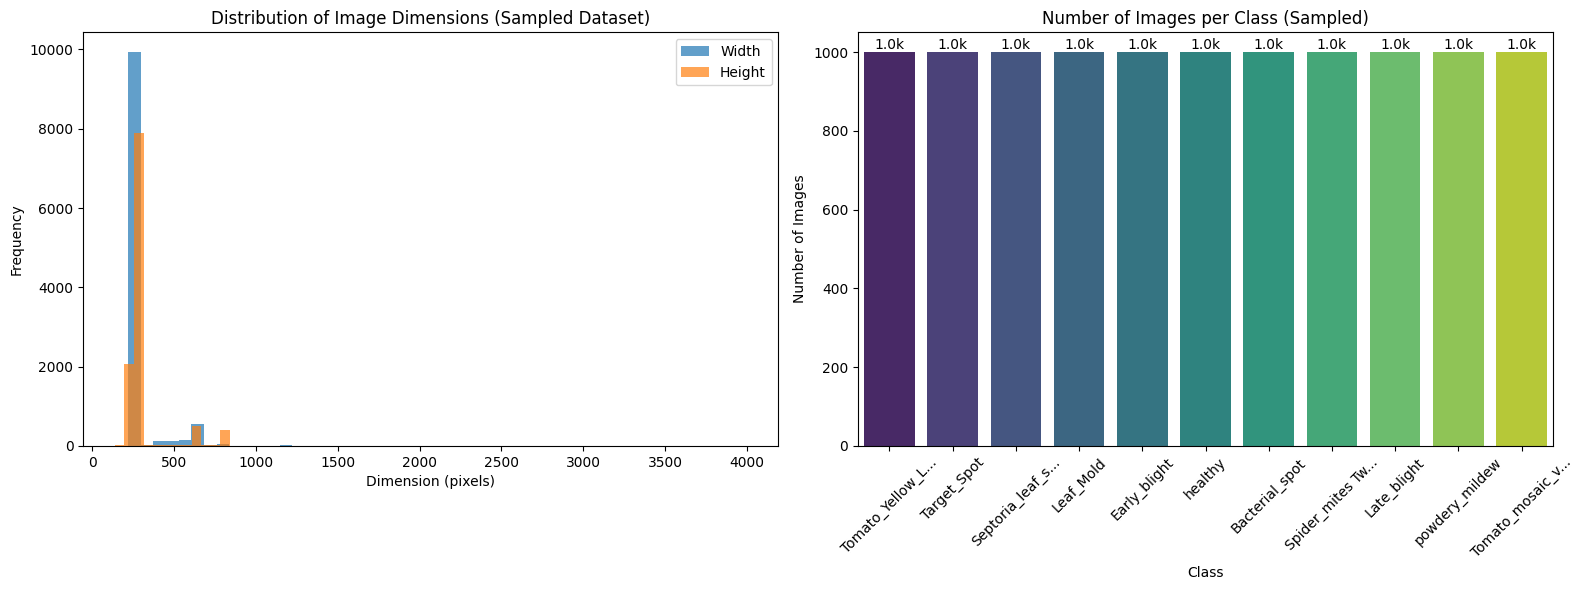

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Analyze the dimensions of images in the DataFrame.
analyze_image_dimensions(sampled_df, 'image', 'Sampled Dataset', ax=axes[0])

# Create a bar chart showing the number of images per class.
create_bar_chart(
    sampled_df['label'].value_counts(),
    'x',
    'Number of Images per Class (Sampled)',
    'Class', 'Number of Images',
    ax=axes[1]
)

plt.tight_layout()
plt.show()


# **3. Modeling**

## **3.1. Data Spliting**

*   **Splits the DataFrame into training and testing sets with stratified sampling**: Partitions the data into training and testing sets while preserving the class distribution, ensuring that the model's evaluation is representative of the overall data and preventing biased performance estimates.


In [ ]:
# Split the DataFrame into training and testing sets
# with stratified sampling.
train_df, test_df = train_test_split(
    sampled_df,
    test_size=0.2,
    random_state=42,
    stratify=sampled_df['label']
)


## **3.2. Data Augmentation**

*   **Creates data generators for training and testing datasets with data augmentation for training**: Applies transformations like rotations, shifts, and flips to the training images, artificially increasing the dataset's size and diversity. This helps the model generalize better to unseen data and reduces the risk of overfitting, where the model performs well on training data but poorly on new examples.


In [ ]:
# Create data generators for training and testing datasets
# with data augmentation for training.
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

# Generate batches of tensor image data for training.
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical'
)

# Generate batches of tensor image data for testing.
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)


Found 8800 validated image filenames belonging to 11 classes.
Found 2200 validated image filenames belonging to 11 classes.


## **3.3. Model Architecture**

*   **Loads the EfficientNetB0 model without the top layer, using pre-trained ImageNet weights. Builds the model by adding custom layers on top of the base model**: Leverages a pre-trained model's knowledge of general image features, saving training time and resources. Custom layers are added to fine-tune the model for the specific task of tomato leaf disease classification, enabling it to learn disease-specific patterns.


In [ ]:
# Load the EfficientNetB0 model without the top layer, using pre-trained
# ImageNet weights
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

# Build the model by adding custom layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(11, activation='softmax')
])


*   **Compiles the model with categorical crossentropy loss, Adam optimizer, and accuracy metric**: Prepares the model for training by specifying the loss function (categorical crossentropy, suitable for multi-class classification), the optimizer (Adam, known for its adaptive learning rates), and the evaluation metric (accuracy, measuring the overall correctness of predictions).


In [ ]:
# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)


## **3.4. Model Training**


*   **Creates a directory for saving the model and defines callbacks for model checkpointing, early stopping, and learning rate reduction**: Sets up mechanisms to save the best-performing model during training (based on validation accuracy), stop training early if performance plateaus to prevent overfitting, and adjust the learning rate dynamically to fine-tune the learning process and potentially improve convergence.


In [ ]:
# Create a directory for saving the model.
os.makedirs('models', exist_ok=True)
checkpoint_filepath = os.path.join('models', 'model.keras')

# ModelCheckpoint Callback to save the best model based on
# validation accuracy.
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
)

# EarlyStopping Callback to stop training when validation accuracy
# stops improving.
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
)

# ReduceLROnPlateau Callback to reduce learning rate when validation
# accuracy plateaus.
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
)


*   **Trains the model with the training data generator, using validation data and callbacks**: Executes the training process, where the model learns to map image features to disease classes by optimizing its parameters to minimize the loss and improve accuracy. The validation data is used to monitor performance on unseen examples, guiding the training process and helping to prevent overfitting.


In [ ]:
# Train the model with the training data generator, using validation
# data and callbacks.
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=test_gen,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.6500 - loss: 1.0516 - val_accuracy: 0.0909 - val_loss: 5.4992 - learning_rate: 0.0010
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 132s 920ms/step - accuracy: 0.8698 - loss: 0.4108 - val_accuracy: 0.0664 - val_loss: 8.6091 - learning_rate: 0.0010
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 132s 921ms/step - accuracy: 0.9102 - loss: 0.2734 - val_accuracy: 0.1009 - val_loss: 4.1853 - learning_rate: 0.0010
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9281 - loss: 0.2249 - val_accuracy: 0.1895 - val_loss: 3.8261 - learning_rate: 0.0010
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 137s 939ms/step - accuracy: 0.9428 - loss: 0.1946 - val_accuracy: 0.2114 - val_loss: 6.0207 - learning_rate: 0.0010
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 135s 898ms/step - accuracy: 0.9463 - loss: 0.1695 - val_accuracy: 0.6145 - val_loss: 1.7396 - learning_rate: 0.0010
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 133s 930ms/step - accuracy: 0.

## **3.5. Model Evaluation**


*   **Plot accuracy and loss comparisons between training and test sets**: Provides insights into the model's learning progress and performance on both training and test data. It helps assess if the model is overfitting (large gap between training and validation metrics) or underfitting (poor performance on both sets), guiding further improvements to the model architecture or training process.


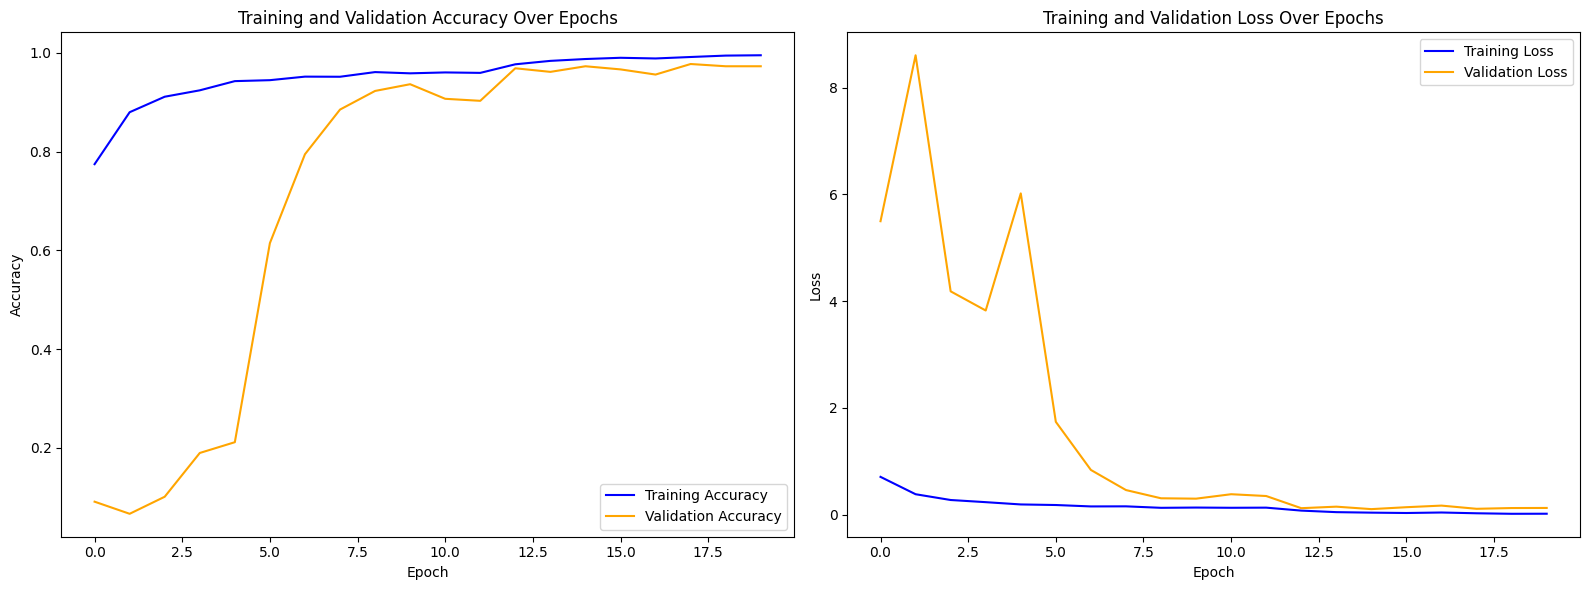

In [ ]:
# Create a figure with two subplots.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracy comparison.
ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy Over Epochs')
ax1.legend()

# Plot loss comparison.
ax2.plot(history.history['loss'], label='Training Loss', color='blue')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss Over Epochs')
ax2.legend()

plt.tight_layout()
plt.show()


The plots illustrate a well-performing model with a slight gap between training and test accuracy and loss, indicating good generalization without overfitting. The model learns effectively from the training data and demonstrates its ability to handle unseen data from the test set. Both training and validation accuracy increase while losses decrease, reaching a plateau towards the end, suggesting that further training might not yield significant improvements.

# **4. Model Convertion**


## **4.1. TFJS**


*   **Converts and saves the Keras model to TensorFlow.js format**: This conversion prepares the model for deployment in web browsers, enabling client-side inference and interactive applications, making the model accessible to a wider audience.


In [ ]:
# Save to "tfjs_model" folder
save_path = os.path.join("models/tfjs_model/")
tfjs.converters.save_keras_model(model, save_path)


failed to lookup keras version from the file,
    this is likely a weight only file
weight normalization_2/count with shape () and dtype int64 was auto converted to the type int32


## **4.2. TF-Lite**


*   **Converts and saves the Keras model to TensorFlow Lite format along with labels**: This optimization process reduces the model's size and improves inference speed, making it suitable for deployment on resource-constrained devices like smartphones and IoT devices, enabling on-device disease detection in real-world scenarios.


In [ ]:
# Save to "tflite" folder
save_path = os.path.join("models/tflite/")
os.makedirs(save_path, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(save_path + 'model_vegs.tflite', 'wb') as f:
    f.write(tflite_model)

# Create labels.txt
with open(save_path + 'labels.txt', 'w') as f:
    f.write('\n'.join(train_gen.class_indices.keys()))


Saved artifact at '/tmp/tmpix8xtqig'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_714')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  140460062212336: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140460062212160: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140460062221136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062212688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062132352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062216912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062213744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062134288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062130944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062138864: TensorSpec(shape=(), dtype=tf.resource, name

## **4.3. savedmodel**


*   **Saves the Keras model in the SavedModel format**: This step stores the model in a format suitable for general TensorFlow serving, allowing for flexible deployment on various platforms and integration with other TensorFlow tools, facilitating broader application and scalability.


In [ ]:
# Save to "saved_model" folder
save_path = "models/saved_model/1/"
model.export(save_path)


Saved artifact at 'models/saved_model/1/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_714')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  140460062212336: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140460062212160: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140460062221136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062212688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062132352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062216912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062213744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062134288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062130944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140460062138864: TensorSpec(shape=(), dtype=tf.resource,

# **5. Inference**


Deploy the trained tomato leaf disease classification model using TensorFlow Serving within a Docker container. This approach provides a robust and scalable solution for serving the model in a production environment.

**Benefits of using TensorFlow Serving and Docker:**

* **Robust and Scalable Deployment:** TensorFlow Serving enables efficient model management, versioning, and handling of incoming inference requests, ensuring a reliable and scalable solution for serving the model.
* **Consistent Deployment Across Environments:** Docker allows the model to be packaged and deployed consistently across various environments, ensuring portability and reproducibility.
* **Real-Time Prediction Capabilities:** This setup enables real-time prediction capabilities for tomato leaf disease classification, allowing for quick and accurate diagnosis based on uploaded images.

**The following steps demonstrate the process of deploying the model:**

1. [**Export the trained model:**](#scrollTo=yEqL9V8KNbin) The trained Keras model is exported in a format suitable for TensorFlow Serving.
2. **Create a Docker image:** A Docker image is built containing TensorFlow Serving and the exported model.
```
docker run -it -v tomato-leaf-disease-classification\models:/models -p 8501:8501 --entrypoint /bin/bash tensorflow/serving
```
3. **Run the Docker container:** The Docker container is launched, exposing a REST API for receiving inference requests.
```
tensorflow_model_server --rest_api_port=8501 --model_name=saved_model --model_base_path=/models/saved_model/
```
4. **Send inference requests:** Client applications can send image data to the REST API, and the model will return predictions regarding the type of tomato leaf disease, which the step is as follows.

## **5.1. Image Preprocessing**

The `images_preprocessing` function prepares an image for input into the trained model.
It takes the filename of an image as input and performs the following steps:
1. Decodes the image from its file format into a tensor with 3 color channels (RGB).
2. Resizes the image to 224x224 pixels, which is the input size expected by the model.
3. Normalizes the pixel values by dividing them by 255, bringing them to a range of 0 to 1.
4. Expands the dimensions of the image tensor to match the model's input format (adding a batch dimension).
5. Converts the tensor to a Python list, suitable for sending to the model for inference.
This function ensures that images are consistently formatted before being fed into the model, promoting accurate and efficient prediction.


In [ ]:
# Function to preprocess images for the model
def images_preprocessing(filename):
    image = tf.io.decode_image(open(filename, 'rb').read(), channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255

    image_tensor = tf.expand_dims(image, 0)
    image_tensor = image_tensor.numpy().tolist()

    return image_tensor

# Dictionary mapping numerical labels to disease names
map_labels = {
    0: "Bacterial_spot",
    1: "Early_blight",
    2: "Late_blight",
    3: "Leaf_Mold",
    4: "Septoria_leaf_spot",
    5: "Spider_mites Two-spotted_spider_mite",
    6: "Target_Spot",
    7: "Tomato_Yellow_Leaf_Curl_Virus",
    8: "Tomato_mosaic_virus",
    9: "healthy",
    10: "powdery_mildew"
}

# Endpoint for the TensorFlow Serving model
endpoint = "http://localhost:8501/v1/models/saved_model:predict"


## **5.2. Single Prediction**

Demonstrates how to use the deployed model to classify a single tomato leaf image.
It takes the filename of an image as input and performs the following steps:
1. `images_preprocessing`: Preprocesses the image using the function defined earlier to prepare it for input into the model.
2. `json_data`: Creates a JSON payload containing the preprocessed image tensor, ready to be sent to the model.
3. `response`: Sends a POST request to the TensorFlow Serving endpoint with the JSON payload.
4. `prediction`: Extracts the predicted label from the model's response. The model outputs a probability distribution over all possible classes, and the `tf.argmax` function finds the class with the highest probability.
5. `actual_label`: Extracts the actual label of the image from its filename (assuming the filename follows a specific structure).
6. `Display the image`: Displays the image with the predicted and actual labels, allowing for visual verification of the model's performance.

The deployed model can be used to make predictions on new images, highlighting the workflow for real-time inference.


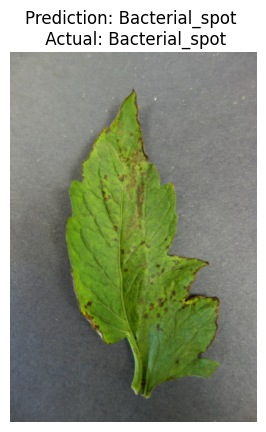

In [ ]:
# Input image.
filename = r"tomato-leaf-disease-classification\images\Bacterial_spot\BS_(73).jpg"
image_tensor = images_preprocessing(filename=filename)

json_data = {
    "instances": image_tensor
}

response = requests.post(endpoint, json=json_data)
prediction = tf.argmax(response.json()['predictions'][0]).numpy()

# Extract actual label from filename.
actual_label = filename.split(os.path.sep)[-2]

# Display the image.
img = tf.io.decode_image(open(filename, 'rb').read(), channels=3)
plt.imshow(img)
plt.title(f"Prediction: {map_labels[prediction]} \n Actual: {actual_label}")
plt.axis('off')
plt.show()


## **5.3. Batch Prediction**
Demonstrates how to use the deployed model to classify multiple tomato leaf images in a batch. It takes a directory containing subfolders of images as input and performs the following steps for each image:
1. `images_preprocessing`: Preprocesses the image using the function defined earlier to prepare it for input into the model.
2. `json_data`: Creates a JSON payload containing the preprocessed image tensor, ready to be sent to the model.
3. `response`: Sends a POST request to the TensorFlow Serving endpoint with the JSON payload.
4. `prediction`: Extracts the predicted label from the model's response. The model outputs a probability distribution over all possible classes, and the `tf.argmax` function finds the class with the highest probability.
5. `Store the image, prediction, and actual label`: Stores the image, its corresponding prediction, and its actual label in lists for later display and evaluation.
6. `Display the images`: Creates a single figure with multiple subplots, each displaying an image along with its predicted and actual labels, allowing for visual verification of the model's performance on a batch of images.

The deployed model can be used to make predictions on a set of images, highlighting the workflow for batch inference and evaluation.



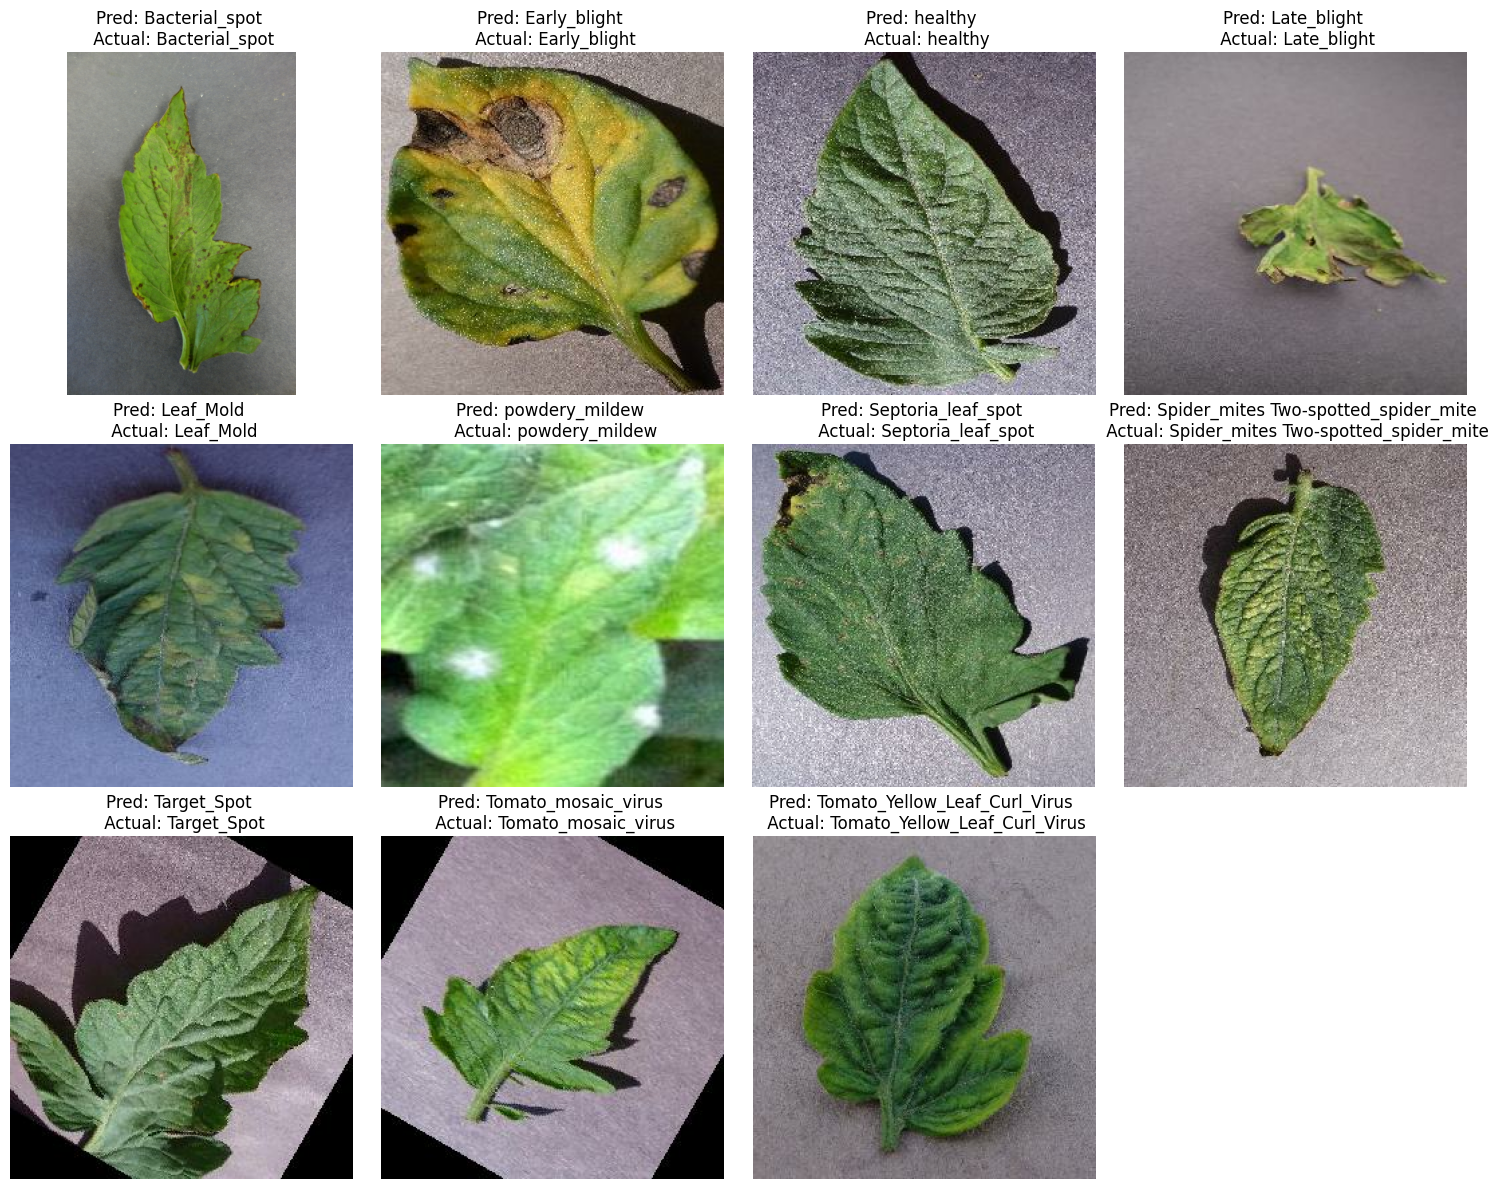

In [ ]:
# Input folder.
image_dir = r"tomato-leaf-disease-classification\images"
subfolders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]

all_images = []
all_predictions = []
all_actual_labels = []

for subfolder in subfolders:
    subfolder_path = os.path.join(image_dir, subfolder)
    image_files = os.listdir(subfolder_path)

    for image_file in image_files:
        image_path = os.path.join(subfolder_path, image_file)
        image_tensor = images_preprocessing(image_path)

        json_data = {
            "instances": image_tensor
        }

        response = requests.post(endpoint, json=json_data)
        prediction = tf.argmax(response.json()['predictions'][0]).numpy()

        # Store the image, prediction, and actual label
        all_images.append(tf.io.decode_image(open(image_path, 'rb').read(), channels=3))
        all_predictions.append(prediction)
        all_actual_labels.append(subfolder)

# Determine the number of rows and columns for the single figure
total_images = len(all_images)
num_cols = 4
num_rows = (total_images + num_cols - 1) // num_cols

# Create the single figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Display all images in the single figure
for i in range(total_images):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.imshow(all_images[i])
    ax.set_title(f"Pred: {map_labels[all_predictions[i]]} \n Actual: {all_actual_labels[i]}")
    ax.axis('off')

# Hide any empty subplots
for i in range(total_images, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# **6. Conclusion**

Comprehensive workflow for building and deploying a tomato leaf disease classification model.
1. **Data Collection and Preparation:** The process begins with collecting a diverse dataset of tomato leaf images representing various diseases and healthy leaves. The data is then preprocessed, including resizing and normalization.
2. **Data Augmentation:** Techniques like rotation, shifting, and flipping are applied to the training images to increase the dataset's size and diversity, leading to better model generalization.
3. **Model Architecture:** A pre-trained EfficientNetB0 model is used as a base, followed by custom layers for fine-tuning the model for the specific task of tomato leaf disease classification.
4. **Model Training:** The model is trained using the prepared dataset, with callbacks for checkpointing, early stopping, and learning rate reduction to optimize the training process.
5. **Model Evaluation:** The trained model's performance is evaluated using metrics like accuracy and loss on both training and validation datasets. Plots are generated to visualize the model's learning progress and identify potential overfitting or underfitting.
6. **Model Conversion:** The trained model is converted to various formats, including TensorFlow.js, TensorFlow Lite, and SavedModel, enabling deployment across different platforms and devices.
7. **Model Deployment:** The model is deployed using TensorFlow Serving within a Docker container, enabling real-time inference and batch prediction capabilities.
8. **Inference:** The deployed model is used to classify single and batch images, demonstrating the workflow for real-time and batch inference.

The demonstrates a powerful tool for early tomato leaf disease detection. The model's accuracy holds great promise for helping farmers and agricultural experts take timely action, safeguarding crops and minimizing losses.


